In [1]:
from GEVnonstat_v2.Automatic_GEV_fit_v2_2 import GEVnonstat
#from GEVnonstat_v3.Automatic_GEV_fit_v3_LBFGSB import GEVnonstat
import pandas as pd
import numpy as np
import dill
import os
from sklearn.preprocessing import StandardScaler

In [2]:
filename = 'daily_Hs_SS_shape_v2.pkl'
if os.path.exists(filename):
    dill.load_session(filename)

In [3]:
data = pd.read_table("Datos\\Hs_SS_PCs_Cantabria.txt")

In [4]:
# Columns for the Hs dataframe
cols_first = ['yyyy', 'mm', 'dd', 'Hs'] + [col for col in data.columns if col.startswith('PC') and not col.endswith('_SS')]

# Columns for the Surge dataframe
cols_second = ['yyyy', 'mm', 'dd', 'Surge'] + [col for col in data.columns if col.endswith('_SS')]

# Create the two DataFrames
df_hs = data[cols_first]
df_surge = data[cols_second]

In [5]:
# Define the days in a month dictionary
days_in_month = {1: 31, 2: 28.25, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

# Correct the time assignment for df_hs
df_hs = df_hs.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_hs['time'] = (
    df_hs['yyyy'] - np.min(df_hs['yyyy'])
    + (df_hs['mm'] - 1) / 12
    + df_hs['dd'] / df_hs['mm'].map(days_in_month) / 12
)

# Correct the time assignment for df_surge
df_surge = df_surge.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_surge['time'] = (
    df_surge['yyyy'] - np.min(df_surge['yyyy'])
    + (df_surge['mm'] - 1) / 12
    + df_surge['dd'] / df_surge['mm'].map(days_in_month) / 12
)


In [6]:
Hsdata = df_hs.drop(columns=["yyyy", "mm", "dd"])
Surgedata = df_surge.drop(columns=["yyyy", "mm", "dd"])

# Fitting daily Hs

In [7]:
hsmax = Hsdata.to_numpy()[:,0]
time = Hsdata.to_numpy()[:,-1]
covariates = {col: Hsdata[col] for col in Hsdata.columns[1:-1]}

In [8]:
covariates_df = pd.DataFrame(covariates)
scaler = StandardScaler()
scaled_covariates_df = pd.DataFrame(
    scaler.fit_transform(covariates_df), 
    columns=covariates_df.columns
)
scaled_covariates = scaled_covariates_df.to_dict(orient='list')

In [9]:
#import warnings
#warnings.filterwarnings("ignore")

In [11]:
autogev_hs = GEVnonstat(xt=hsmax,t=time,kt=None,covariates=scaled_covariates,example="Hs Daily",trends=False, harm=False)
beta0,beta,alpha0,alpha,gamma0,gamma,betaT,auxvarphi_loc,list_loc,betaT2,auxvarphi_sc,list_sc,auxvarphi_sh,list_sh,loglikeobj,grad,hessian,popt,stdpara = autogev_hs.AutoAdjust()

Stationary GEV AIC: 39746.5713826633 

Starting the Covariates iterative process


Covariate Iteration:   8%|▊         | 17/200 [01:05<11:49,  3.88s/it]


End of the Covariates iterative process
Covariates AIC: 21355.238694755873 



The optimal parameters are in the below table, where the location, scale and shape parameters are defiend as:
$$
\begin{align*}
\mu_t &= \beta_{0} + \beta_{0}^{co} PC_{0} + \beta_{1}^{co} PC_{1} + \dots + \beta_{99}^{co} PC_{99} \\
\psi_t &= \alpha_{0} + \alpha_{0}^{co} PC_{0} + \alpha_{1}^{co} PC_{1} + \dots + \alpha_{99}^{co} PC_{99} \\
\xi_t &= \gamma_{0} + \gamma_{0}^{co} PC_{0} + \gamma_{1}^{co} PC_{1} + \dots + \gamma_{99}^{co} PC_{99} 
\end{align*}
$$

In [12]:
complete_varphi = np.zeros(100)
complete_varphi2 = np.zeros(100)
complete_varphi3 = np.zeros(100)
complete_varphi[list_loc] = auxvarphi_loc
complete_varphi2[list_sc] = auxvarphi_sc
complete_varphi3[list_sh] = auxvarphi_sh
cov_dict = {
    "Parameter": ["Location (mu)", "Scale (psi)","Shape (xi)"],
    "Intercept": [beta0, alpha0, gamma0]
    }
for i in range(100):
    name = f"PC{i}"
    cov_dict[name] = [complete_varphi[i], complete_varphi2[i], complete_varphi3[i]]
result_df = pd.DataFrame(cov_dict)
result_df = result_df.replace({0: "--", None: "--", np.nan: "--"})
print(result_df.to_string(index=False))

    Parameter Intercept       PC0       PC1 PC2       PC3       PC4       PC5 PC6 PC7       PC8 PC9      PC10 PC11 PC12 PC13 PC14      PC15      PC16 PC17 PC18 PC19 PC20 PC21 PC22 PC23     PC24 PC25 PC26 PC27      PC28 PC29 PC30 PC31      PC32 PC33 PC34 PC35 PC36 PC37 PC38 PC39 PC40 PC41 PC42      PC43 PC44 PC45 PC46 PC47 PC48 PC49 PC50 PC51 PC52 PC53 PC54 PC55 PC56 PC57 PC58 PC59 PC60 PC61 PC62 PC63      PC64 PC65 PC66 PC67 PC68 PC69 PC70 PC71 PC72 PC73 PC74 PC75 PC76 PC77 PC78 PC79 PC80 PC81 PC82 PC83 PC84 PC85 PC86 PC87 PC88 PC89 PC90 PC91 PC92 PC93 PC94 PC95 PC96 PC97 PC98 PC99
Location (mu)  1.800494  0.522488 -0.361932  --  0.318068    0.2371  0.120179  --  -- -0.136152  --  0.161682   --   --   --   --  0.167113 -0.090419   --   --   --   --   --   --   --  0.14652   --   --   --  0.089261   --   --   --  0.047801   --   --   --   --   --   --   --   --   --   --  0.072042   --   --   --   --   --   --   --   --   --   --   --   --   --   --   --   --   --   --   --   -- -0.1257

c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_2.py:2203: RuntimeWarning: invalid value encountered in sqrt
  stdpsit = np.sqrt(np.sum((Derpsit.T@self.invI0[1+2*self.nmu+self.ntend_loc+self.nind_loc:2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc,1+2*self.nmu+self.ntend_loc+self.nind_loc:2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc])*Derpsit.T, axis = 1))


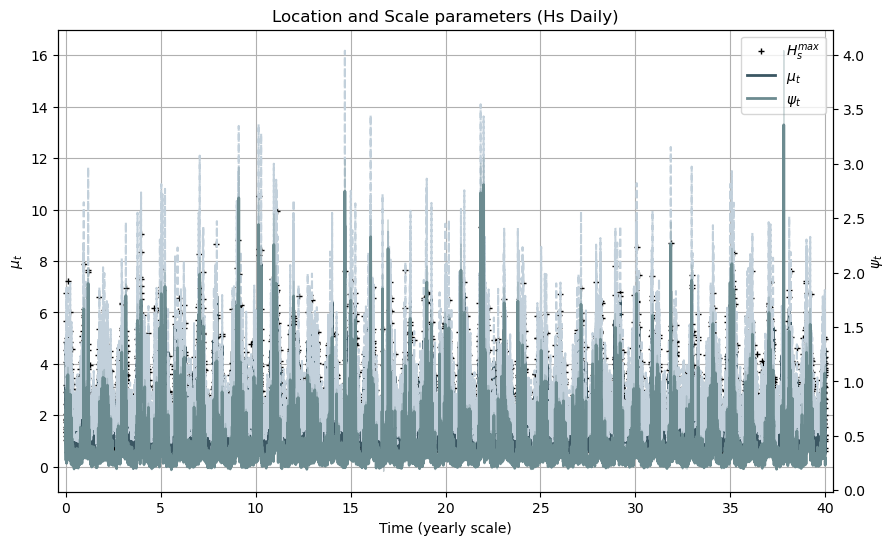

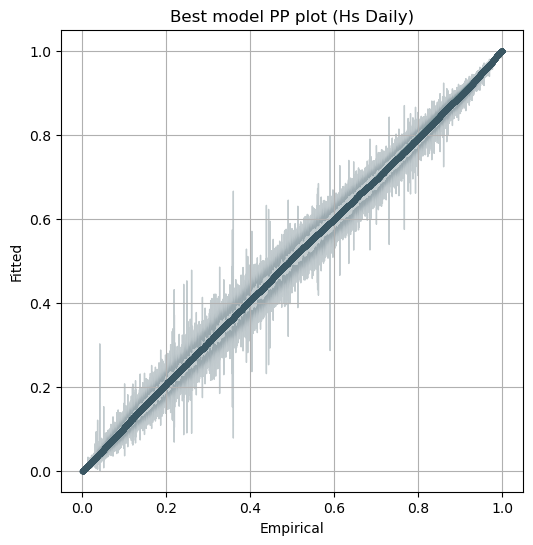

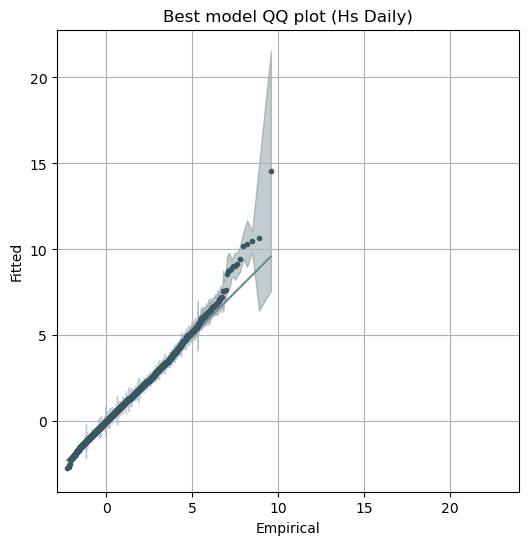

In [12]:
autogev_hs.plot()

# Fitting daily Surge Storm data

In [12]:
ssdaily = Surgedata.to_numpy()[:,0]
time_surge = Surgedata.to_numpy()[:,-1]
covariates_surge = {col: Surgedata[col] for col in Surgedata.columns[1:-1]}

In [13]:
covariates_surge_df = pd.DataFrame(covariates_surge)
scaler = StandardScaler()
scaled_covariates_surge_df = pd.DataFrame(
    scaler.fit_transform(covariates_surge_df),
    columns=covariates_surge_df.columns
)
scaled_covariates_surge = scaled_covariates_surge_df.to_dict(orient='list')

In [14]:
autogev_ss = GEVnonstat(xt=ssdaily,t=time_surge,kt=None,covariates=scaled_covariates_surge,example="SS Daily",trends=False, harm=False)
beta0,beta,alpha0,alpha,gamma0,gamma,betaT,auxvarphi_loc,list_loc,betaT2,auxvarphi_sc,list_sc,auxvarphi_sh,list_sh,loglikeobj,grad,hessian,popt,stdpara = autogev_ss.AutoAdjust()

Stationary GEV AIC: -29095.151437802902 

Starting the Covariates iterative process


Covariate Iteration:   2%|▏         | 5/225 [00:23<18:39,  5.09s/it]c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_1.py:1082: RuntimeWarning: overflow encountered in power
  zn = z**(-1/epst)
Covariate Iteration:   8%|▊         | 18/225 [01:18<15:05,  4.37s/it]


End of the Covariates iterative process
Covariates AIC: -78118.45884355737 



c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_1.py:664: RuntimeWarning: invalid value encountered in sqrt
  stdpara = np.sqrt(np.diag(invI0))


In [15]:
complete_varphi = np.zeros(100)
complete_varphi2 = np.zeros(100)
complete_varphi3 = np.zeros(100)
complete_varphi[list_loc] = auxvarphi_loc
complete_varphi2[list_sc] = auxvarphi_sc
complete_varphi3[list_sh] = auxvarphi_sh
cov_dict = {
    "Parameter": ["Location (mu)", "Scale (psi)","Shape (xi)"],
    "Intercept": [beta0, alpha0, gamma0]
    }
for i in range(100):
    name = f"PC{i}"
    cov_dict[name] = [complete_varphi[i], complete_varphi2[i], complete_varphi3[i]]
result_df = pd.DataFrame(cov_dict)
result_df = result_df.replace({0: "--", None: "--", np.nan: "--"})
print(result_df.to_string(index=False))

    Parameter  Intercept      PC0       PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10     PC11     PC12     PC13      PC14      PC15      PC16      PC17      PC18      PC19      PC20      PC21      PC22      PC23      PC24      PC25      PC26      PC27      PC28      PC29      PC30      PC31      PC32      PC33      PC34      PC35      PC36      PC37      PC38      PC39      PC40      PC41      PC42      PC43      PC44      PC45     PC46      PC47      PC48      PC49      PC50      PC51      PC52      PC53      PC54      PC55      PC56      PC57     PC58      PC59      PC60      PC61      PC62      PC63      PC64      PC65      PC66      PC67      PC68      PC69      PC70      PC71      PC72      PC73     PC74 PC75 PC76 PC77 PC78 PC79 PC80 PC81 PC82 PC83 PC84 PC85 PC86 PC87 PC88 PC89 PC90 PC91 PC92 PC93 PC94 PC95 PC96 PC97 PC98 PC99
Location (mu)  -0.016137 0.073459 -0.029940  0.035379  0.001652  0.007399 -0.000614  0.002481 -0.002974 -0.

c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_1.py:2120: RuntimeWarning: invalid value encountered in sqrt
  stdmut = np.sqrt(np.sum((Dermut.T@self.invI0[:1+2*self.nmu+self.ntend_loc+self.nind_loc,:1+2*self.nmu+self.ntend_loc+self.nind_loc])*Dermut.T, axis = 1))
c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_1.py:2123: RuntimeWarning: invalid value encountered in sqrt
  stdepst = np.sqrt(np.sum((Derepst.T@self.invI0[2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc:2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc+self.neps0+2*self.neps+self.nind_sh, 2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc:2+2*self.nmu+self.ntend_loc+self.nind_loc+2*self.npsi+self.ntend_sc+self.nind_sc+self.neps0+2*self.neps+self.nind_sh])*Derepst.T, axis = 1))
c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_1.py:2127: Runtime

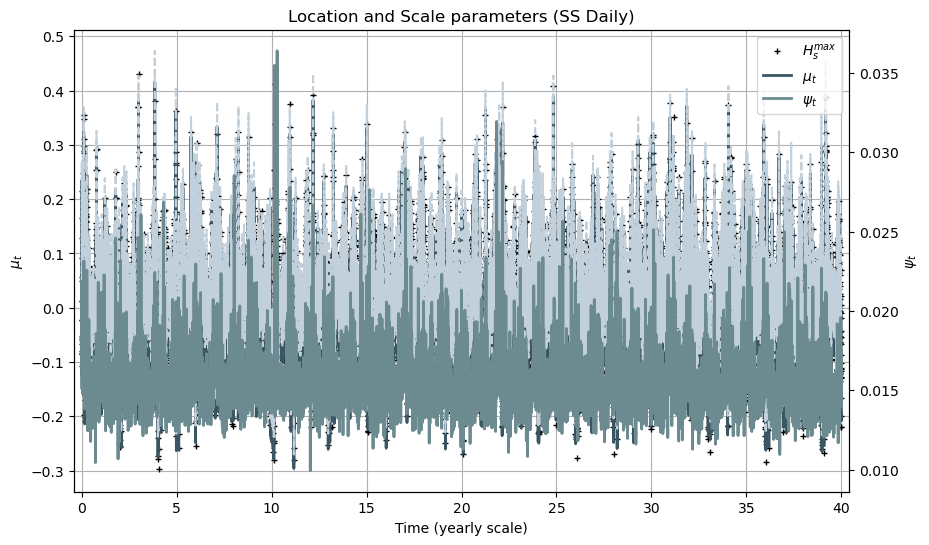

c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_1.py:2674: RuntimeWarning: invalid value encountered in power
  F[pos] = np.exp(-self.kt[pos]*(1+epst[pos]*((self.xt[pos]-mut[pos])/psit[pos]))**(-1/epst[pos]))
c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_1.py:2304: RuntimeWarning: invalid value encountered in log
  Zt[pos] = (1/epst[pos])*np.log(1+epst[pos]*((self.xt[pos]-mut[pos])/psit[pos]))
c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_1.py:2627: RuntimeWarning: invalid value encountered in sqrt
  stdDwei = np.sqrt(np.sum((Dwei.T @ self.invI0) * Dwei.T, axis=1))


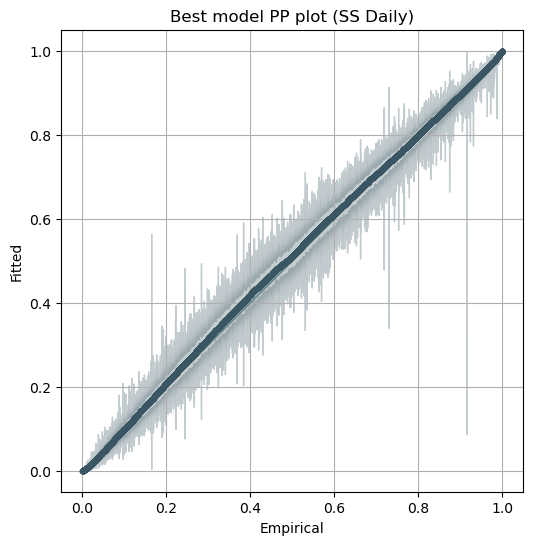

c:\Users\user\Victor\NoEstacionario\Python\GEVnonstat_v2\Automatic_GEV_fit_v2_1.py:2258: RuntimeWarning: invalid value encountered in sqrt
  stdDwei = np.sqrt(np.sum((Dwei.T @ self.invI0) * Dwei.T, axis=1))


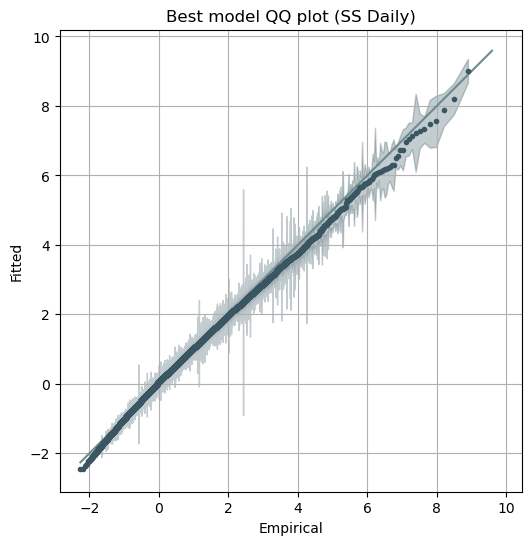

In [16]:
autogev_ss.plot()

In [17]:
autogev_ss._AIC(loglikeobj,303)

-78416.86852807106

In [ ]:
filename = 'daily_Hs_SS_shape_v2.pkl'
dill.dump_session(filename)